# Compare a few ways to generate synthetic forecasts

In this notebook we explore a few different ways to fit AR models to real data to generate synthetic observation/ensemble-hindcast data. The goal here is to come up with an approach for generating synthetic ensemble forecast data that have appropriately similar statistical properties (along time at a given lead) to real GCM forecast data. The idea is that if we can do this robustly, then we can use these synthetic observation/ensemble-hindcast data to more rigorously investigate a number of interesting topics in multi-year climate forecasting, including
- inference of forecast skill using the Pearson correlation coefficient
- the signal-to-noise paradox

In [1]:
%cd /g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory

/g/data/xv83/users/ds0092/active_projects/Squire_2022_correlation/notebooks/exploratory


In [2]:
import xarray as xr

import numpy as np

from itertools import cycle

import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs

from src import data, utils, stats, ar_model

import warnings

warnings.filterwarnings("ignore")

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [34]:
matplotlib.rcParams["figure.figsize"] = (14, 7)
matplotlib.rcParams["font.size"] = 12

In [5]:
DATA_DIR = "../../data/processed/"

# A) Load some SST data to play with

Here we load three different SST datasets and process them to detrended anomalies of annual means on a 5x5 deg regular grid:

- **HadISST**: single member reanalysis spanning 1870  - 2021
- **HadGEM3-GC31-MM CMIP6 historical run**: four member forced historical run spanning 1850 - 2014
- **HadGEM3-GC31-MM CMIP6 DCPP runs**: ten member decadal hindcasts initialised every Nov over 1960 - 2020

Anomalisation/detrending is relative to the full available period for each dataset. For the hindcast data, anomalisation/detrending is performed at each forecast lead separately.

In [6]:
def prep_data(ds, hindcast=False):
    """
    Some steps to prepare some data. If processing a hindcast, set
    hindcast=True
    """

    if hindcast:
        coarsen_dim = "lead"
        mean_dim = "init"
    else:
        coarsen_dim = mean_dim = "time"

    # In case time is a dask array
    ds = ds.assign_coords({"time": ds.time.compute()})

    # Annual 1-12 months
    ds = utils.get_consecutive_month_avg(ds, range(1, 13), time_dim=coarsen_dim)

    # 5x5 deg grid
    ds = data.interpolate_to_regular_grid(ds.chunk({"lat": -1, "lon": -1}), 5)

    # Anomalies
    ds = ds - ds.mean(mean_dim)

    # Detrend
    ds = utils.detrend(ds, dim=mean_dim)

    return ds.compute()

### Reanalysis data: HadISST

In [11]:
ds = prep_data(xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True))
reanalysis = ds.assign_coords({"time": ds.time.dt.year}).rename({"sst": "tos"})

### CMIP6 historical run: HadGEM3-GC31-MM

In [13]:
model = "HadGEM3-GC31-MM"

ds = prep_data(
    xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_historical.zarr", use_cftime=True),
)
historical = ds.assign_coords({"time": ds.time.dt.year})

### CMIP6 DCPP runs: HadGEM3-GC31-MM

In [15]:
ds = prep_data(
    xr.open_zarr(f"{DATA_DIR}/tos_Omon_{model}_dcpp.zarr", use_cftime=True),
    hindcast=True,
)
hindcast = ds.assign_coords(
    {"init": ds.init.dt.year, "lead": range(1, ds.sizes["lead"] + 1)}
)

### Mask the land

In [18]:
mask = (
    reanalysis["tos"].sum("time", skipna=False).notnull()
    & historical["tos"].sum(["time", "member"], skipna=False).notnull()
    & hindcast["tos"].sum(["init", "lead", "member"], skipna=False).notnull()
)

reanalysis = xr.where(mask, reanalysis, 0)
historical = xr.where(mask, historical, 0)
hindcast = xr.where(mask, hindcast, 0)

# B) Fit an AR(3) model to each dataset

We derive AR(3) coefficients at every grid cell in a number of different ways:

- fit, along time, the HadISST reanalysis
- fit, along time, all (four) members of the HadGEM3-GC31-MM CMIP6 historical run
- fit, along lead, all forecasts and (ten) members of the HadGEM3-GC31-MM CMIP6 DCPP runs
- fit, along lead, all forecasts and (ten) members of the HadGEM3-GC31-MM CMIP6 DCPP runs, also prepending one year of HadISST to the beginning of each forecast

In [19]:
n_lags = 3

params = {}

params["HadISST"] = ar_model.fit(reanalysis, n_lags=n_lags)

params[f"{model}\nhistorical"] = ar_model.fit(historical, n_lags=n_lags)

params[f"{model}\nhindcast"] = ar_model.fit(hindcast, n_lags=n_lags, dim="lead")

reanalysis_init = (
    reanalysis.sel(time=hindcast.sel(lead=1).time.dt.year.values - 1)
    .rename({"time": "init"})
    .assign_coords({"lead": 0})
)
hindcast_prepend = xr.concat([reanalysis_init, hindcast.drop("time")], dim="lead")
params[f"{model}\nhindcast preprended"] = ar_model.fit(
    hindcast_prepend,
    n_lags=n_lags,
    dim="lead",
)

### How do the params compare?

The following plot shows the AR coefficients and noise term for each of the different fits

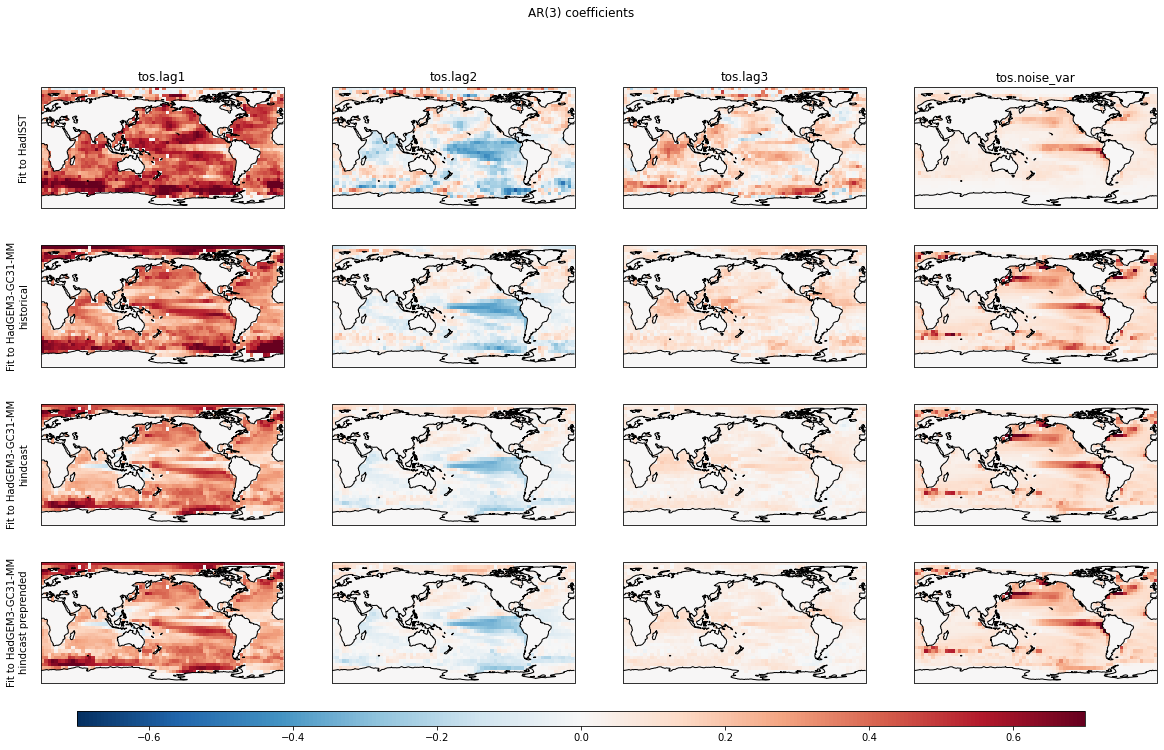

In [20]:
fig = plt.figure(figsize=(5 * (n_lags + 1), 2.6 * len(params)))
axs = fig.subplots(
    len(params),
    n_lags + 1,
    subplot_kw=dict(projection=ccrs.PlateCarree(180), sharex=True, sharey=True),
)
vrange = (-0.7, 0.7)

for idy, (name, ds) in enumerate(params.items()):
    for idx, param in enumerate(ds.params.values):
        ax = axs[idy, idx]
        p = (
            ds[list(ds.data_vars)[0]]
            .sel(params=param)
            .plot(
                ax=ax,
                transform=ccrs.PlateCarree(),
                cmap="RdBu_r",
                add_colorbar=False,
                vmin=vrange[0],
                vmax=vrange[1],
            )
        )

        p.axes.set_global()
        p.axes.coastlines()
        ax.set_title("")
        if idx == 0:
            ax.text(
                -0.05,
                0.5,
                f"Fit to {name}",
                va="bottom",
                ha="center",
                rotation="vertical",
                rotation_mode="anchor",
                transform=ax.transAxes,
                wrap=True,
            )
        if idy == 0:
            ax.set_title(param)

fig.suptitle("AR(3) coefficients")

fig.subplots_adjust(bottom=0.07)
cbar_ax = fig.add_axes([0.15, 0.02, 0.7, 0.02])
_ = fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

# C) Generate some synthetic hindcasts
One overarching aim here is to generate independent pairs of synthetic observations and ensemble hindcasts that have similar statistical properties (distributions, ACFs) to real observations/hindcasts. 
1. The synthetic observations are simple to generate using one of our AR models (e.g. the fit to the HadISST reanalysis). We shall demonstrate this first below.
2. The current approach for generating synthetic ensemble forecasts is to run one of our AR models forward in time from a set of initial conditions. The initial condition for each $N_{member}$ ensemble member in a forecast is the same, but their trajectories differ because the noise component is different for each member. In practice, these forecasts will be initialised from a set synthetic observations generated in the same way as in 1., but independent of those synthetic observations.

## Generate some synthetic observations from the HadISST AR coefficients
We first generate some synthetic timeseries using the AR coefficients from the fit to the HadISST reanalysis. In the following we generate 100 synthetic SST timeseries at each grid cell.

In [21]:
n_samples = 100

synth_timeseries = ar_model.generate_samples(
    params["HadISST"], n_times=reanalysis.sizes["time"], n_samples=n_samples
)

Append the HadISST as the -1th sample as it will be handy to have later on

In [22]:
synth_timeseries["time"] = reanalysis["time"]
synth_timeseries = xr.concat(
    [reanalysis.assign_coords(sample=[-1]), synth_timeseries],
    dim="sample",
)

### How do the ACFs for these synthetic timeseries compare to the HadISST reanalysis ACF?

Here we "assess" the synthetic ACFs relative to the HadISST ACF at each grid cell by checking whether the HadISST ACF falls within 2.5-97.5% confidence bounds generated from multiple samples of the synthetic ACF. This test has a number of issues, but it will do for now.

As an example, the plot below shows the HadISST ACF (black) and the 100 synthetic AR(3) ACFs at a particular grid cell. At this particular location, the HadISST ACF falls within the 2.5-97.5% confidence bounds of the synthetic ACFs, so we consider our AR model at this location to be adequate for simulating timeseries.

In [23]:
reanalysis_acf = stats.acf(reanalysis, dim="time", nlags=n_lags)
synth_timeseries_acf = stats.acf(
    synth_timeseries.sel(sample=slice(0, None)), dim="time", nlags=n_lags
)

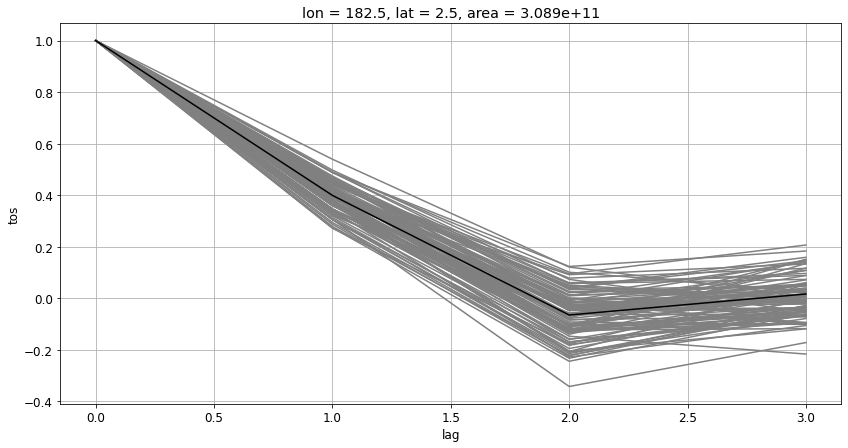

In [35]:
ilocation = dict(lon=36, lat=18)

synth_timeseries_acf["tos"].isel(ilocation).plot.line(
    x="lag", color="grey", add_legend=False
)
reanalysis_acf["tos"].isel(ilocation).plot(color="k")
plt.grid()

We can run this test at all locations, where green indicates the test passed and red indicates it failed

In [15]:
def is_consistent(baseline, samples):
    """
    Return Trues where the baseline falls within confidence bounds generated
    from multiple samples
    """
    quantile_bounds = (0.025, 0.975)

    lower = samples.quantile(quantile_bounds[0], dim="sample")
    upper = samples.quantile(quantile_bounds[1], dim="sample")

    return (baseline >= lower) & (baseline <= upper)

In [ ]:
consistent_ts = is_consistent(reanalysis_acf, synth_timeseries_acf).all("lag")

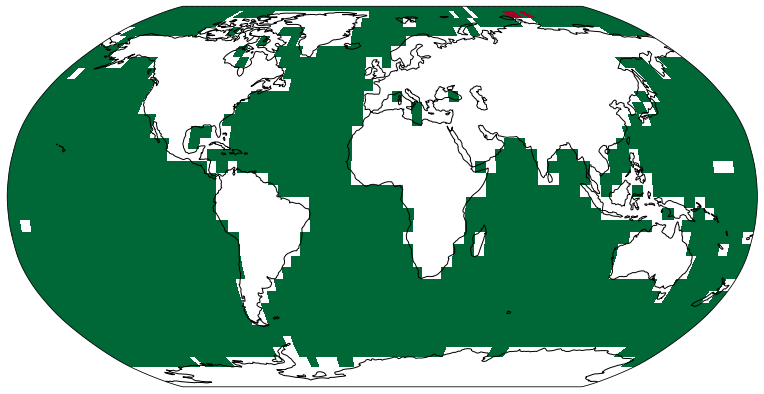

In [27]:
p = (
    consistent_ts["tos"]
    .where(mask)
    .plot(
        subplot_kws=dict(projection=ccrs.Robinson()),
        transform=ccrs.PlateCarree(),
        cmap="RdYlGn",
        add_colorbar=False,
    )
)

p.axes.set_global()
_ = p.axes.coastlines()

So, perhaps unsurprisingly, our synthethic timeseries look broadly consistent with the HadISST data (at least in terms of the ACF).

### Now let's try to generate some synthetic hindcasts

As explained above, we generate synthetic ensemble hindcasts by running an ensemble AR model forward in time from a set of initial conditions. Here, we are looking to assess how well our synthetic hindcasts compare to real GCM hindcast. We've just seen that we can do an okay job of generating synthetic timeseries using an AR process, so we'll use these as initial conditions for our synthetic forecasts and then compare our synthetic forecasts to real GCM forecasts. In order to do this comparison, we should be careful that our synthetic and real forecasts have the same number of initial dates and ensemble members.

Below we generate 100 sets of synthetic ensemble hindcasts using the 100 synthetic timeseries from above as initial conditions. Each ensemble hindcast set has 61 initial dates, 10 members and is run for 10 years (like the HadGEM3-GC31-MM CMIP6 DCPP hindcasts). We generate synthetic hindcasts using each of the AR parameters from B.

In [18]:
synth_hindcast = {
    name: ar_model.predict(
        param,
        synth_timeseries.sel(
            time=slice(
                min(hindcast.init.values) - n_lags + 1, max(hindcast.init.values)
            )
        ),
        n_steps=hindcast.sizes["lead"],
        n_members=hindcast.sizes["member"],
    )
    for name, param in params.items()
}

Let's quickly visualise some of these forecasts

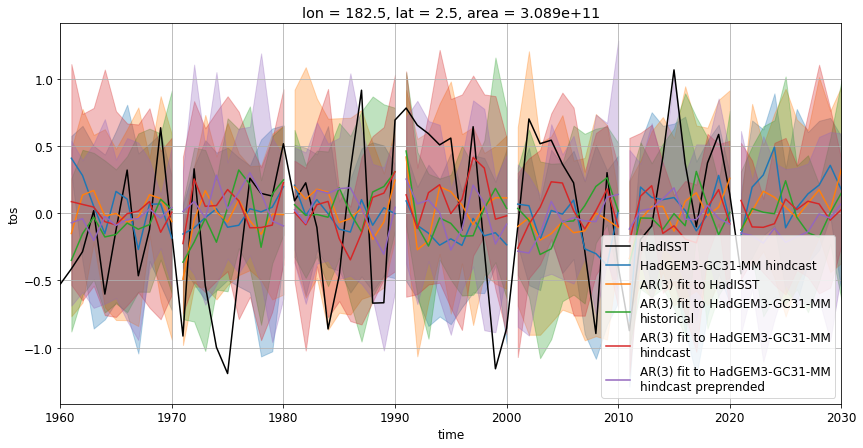

In [28]:
iloc = dict(lat=18, lon=36)
inits = range(1960, 2021, 10)

reanalysis["tos"].isel(iloc).plot(color="k", label="HadISST")

colors = [f"C{i}" for i in range(len(synth_hindcast) + 1)]
colorcycler = cycle(colors)

for idx, year in enumerate(inits):
    color = next(colorcycler)
    label = f"HadGEM3-GC31-MM hindcast" if idx == 0 else "__nolabel__"
    hcst = hindcast["tos"].isel(iloc).sel(init=year)
    plt.fill_between(
        year + hcst.lead,
        hcst.quantile(0.05, "member"),
        hcst.quantile(0.95, "member"),
        color=color,
        alpha=0.3,
    )
    plt.plot(year + hcst.lead, hcst.mean("member"), color=color, label=label)

    for fit, synth_hcst in synth_hindcast.items():
        color = next(colorcycler)
        label = f"AR(3) fit to {fit}" if idx == 0 else "__nolabel__"
        hcst = synth_hcst["tos"].isel(iloc).sel(sample=-1, init=year)
        plt.fill_between(
            year + hcst.lead,
            hcst.quantile(0.05, "member"),
            hcst.quantile(0.95, "member"),
            color=color,
            alpha=0.3,
        )
        plt.plot(year + hcst.lead, hcst.mean("member"), color=color, label=label)

plt.xlim(1960, 2030)
plt.grid()
_ = plt.legend()

### How do the ACFs **along lead time** for these synthetic hindcasts compare to real climate hindcasts?

Here we "assess" the synethic ACFs in the same way as above and we compare the ACF of the ensemble mean averaged across all inital dates

In [20]:
consistent_hcst_lag = {}

for fit, synth in synth_hindcast.items():
    hindcast_acf = stats.acf(hindcast.mean("member"), dim="lead", nlags=n_lags).mean(
        "init"
    )
    synth_hindcast_acf = stats.acf(
        synth.sel(sample=slice(0, None)).mean("member"), dim="lead", nlags=n_lags
    ).mean("init")

    consistent_hcst_lag[fit] = is_consistent(hindcast_acf, synth_hindcast_acf).all(
        "lag"
    )

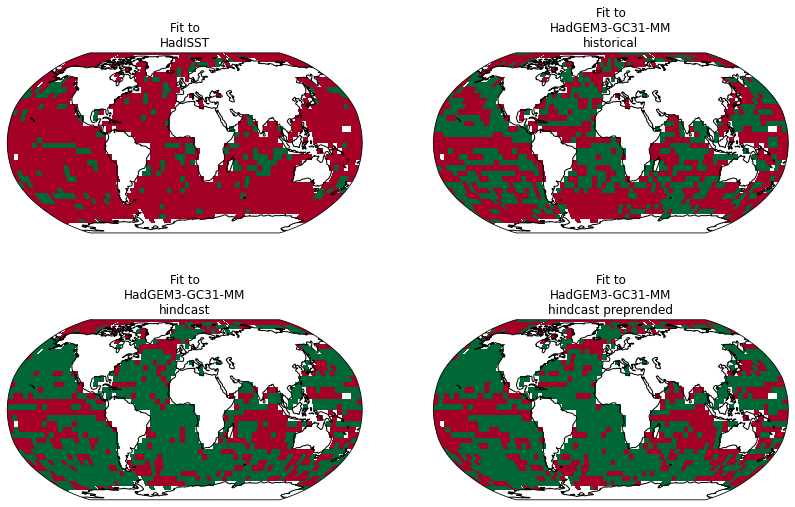

In [21]:
fig = plt.figure(figsize=(14, 9))
axs = fig.subplots(
    2,
    2,
    subplot_kw=dict(projection=ccrs.Robinson(), sharex=True, sharey=True),
)

for ax, (fit, plot) in zip(axs.flatten(), consistent_hcst_lag.items()):
    p = (
        plot["tos"]
        .where(mask)
        .plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="RdYlGn",
            add_colorbar=False,
        )
    )

    p.axes.set_title(f"Fit to\n{fit}")
    p.axes.set_global()
    _ = p.axes.coastlines()

So there are lots of locations where our test fails. I don't really understand why this is. Let's look at a location where the test failed, e.g. in the Tropical Pacific Ocean

### How do the ACFs **along time** for these synthetic hindcasts compare to real climate hindcasts at a particular lead?


### Lead: 1 year

In [22]:
consistent_hcst_time_1 = {}

for fit, synth in synth_hindcast.items():
    hindcast_acf = stats.acf(
        hindcast.sel(lead=1).mean("member"), dim="init", nlags=n_lags
    )
    synth_hindcast_acf = stats.acf(
        synth.sel(sample=slice(0, None), lead=1).mean("member"),
        dim="init",
        nlags=n_lags,
    )

    consistent_hcst_time_1[fit] = is_consistent(hindcast_acf, synth_hindcast_acf).all(
        "lag"
    )

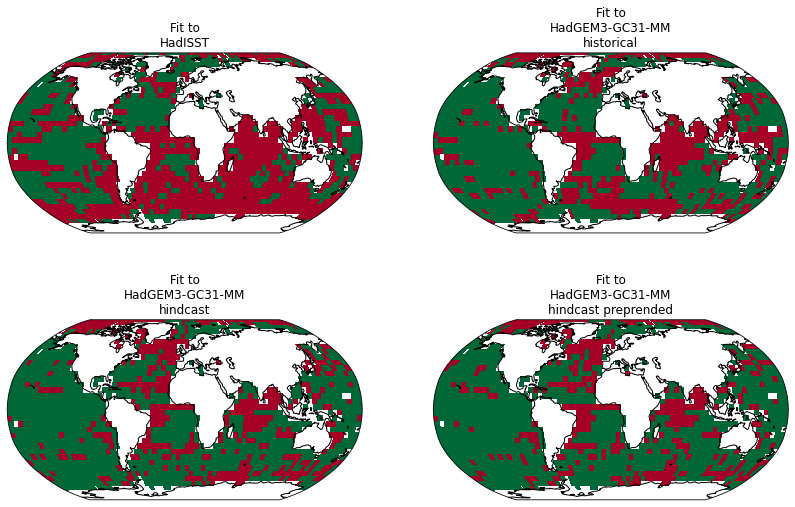

In [23]:
fig = plt.figure(figsize=(14, 9))
axs = fig.subplots(
    2,
    2,
    subplot_kw=dict(projection=ccrs.Robinson(), sharex=True, sharey=True),
)

for ax, (fit, plot) in zip(axs.flatten(), consistent_hcst_time_1.items()):
    p = (
        plot["tos"]
        .where(mask)
        .plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="RdYlGn",
            add_colorbar=False,
        )
    )

    p.axes.set_title(f"Fit to\n{fit}")
    p.axes.set_global()
    _ = p.axes.coastlines()

### Lead: 1-4 year average

In [24]:
consistent_hcst_time_4 = {}

for fit, synth in synth_hindcast.items():
    hindcast_acf = stats.acf(
        hindcast.sel(lead=slice(1, 4)).mean(["member", "lead"]),
        dim="init",
        nlags=n_lags,
    )
    synth_hindcast_acf = stats.acf(
        synth.sel(sample=slice(0, None), lead=slice(1, 4)).mean(["member", "lead"]),
        dim="init",
        nlags=n_lags,
    )

    consistent_hcst_time_4[fit] = is_consistent(hindcast_acf, synth_hindcast_acf).all(
        "lag"
    )

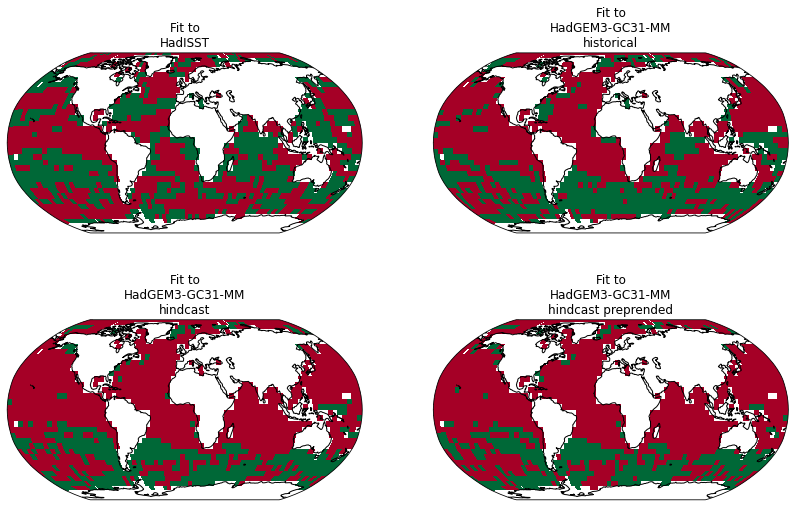

In [25]:
fig = plt.figure(figsize=(14, 9))
axs = fig.subplots(
    2,
    2,
    subplot_kw=dict(projection=ccrs.Robinson(), sharex=True, sharey=True),
)

for ax, (fit, plot) in zip(axs.flatten(), consistent_hcst_time_4.items()):
    p = (
        plot["tos"]
        .where(mask)
        .plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap="RdYlGn",
            add_colorbar=False,
        )
    )

    p.axes.set_title(f"Fit to\n{fit}")
    p.axes.set_global()
    _ = p.axes.coastlines()